# Copyright
This notebook provides the code blocks of TowardsMachineLearning's CLIP model tutorial. I just added some visualizations to see how the model works, examine the parameters, examine the vector dimensions resulting from the operation of the image/text encoders, and see how the embeddings work.

You can see the original blog post, all rights of this code belong to the blog owner, except for the figures created: https://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2



## Introduction

In [ ]:
!pip install timm
!pip install transformers

In [1]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from time import gmtime, strftime
import pickle

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

<ipython-input-1-c8da7417f538>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


cuda


In [ ]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "unatteksen"
os.environ['KAGGLE_KEY'] = "kaggle.json"

### For Flickr 8k
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"

## Some pre-preocessing

In [3]:
df = pd.read_csv("captions.txt")
df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
df.to_csv("captions.csv", index=False)
df = pd.read_csv("captions.csv")
image_path = "/content/Images"
captions_path = "/content"


print(len(df))
df.head()

40455


,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


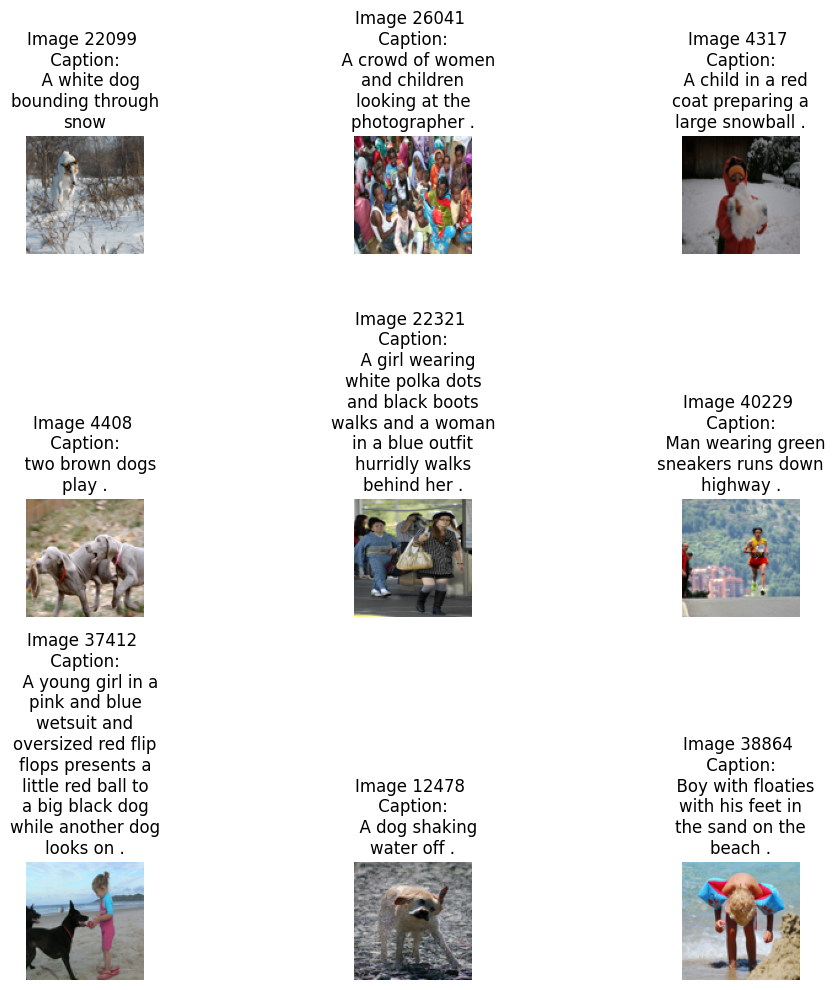

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import requests
from PIL import Image
from io import BytesIO
import random


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(image_sources):
    num_images = len(image_sources)

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(3, 3)

    for i, img_src in enumerate(image_sources):
        try:
            img = mpimg.imread("/"+str(image_path)+"/"+str(df.image[img_src]))
            ax = fig.add_subplot(gs[i])
            img = np.copy(img)
            img = resize_image(img, (96, 96))
            ax.imshow(img)
            caption = f"{split_caption(df.caption[img_src])}"
            ax.set_title(caption)
            ax.set_title(f"Image {img_src+1} \n Caption: \n {caption}")
            ax.axis('off')
        except Exception as e:
            print(f"Error displaying image {i+1}: {e}")

    plt.tight_layout()
    plt.show()

image_sources = [random.randint(0, len(df)) for _ in range(9)]

def resize_image(img, target_size):
    return np.array(Image.fromarray(img).resize(target_size))


def split_caption(caption, max_chars_per_line=18):
    words = caption.split()
    lines = []
    current_line = ''
    for word in words:
        if len(current_line) + len(word) + 1 <= max_chars_per_line:
            current_line += ' ' + word
        else:
            lines.append(current_line)
            current_line = word
    if current_line:
        lines.append(current_line)
    return '\n'.join(lines)

display_images(image_sources)


## Utils

In [5]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


## Dataset

In [6]:
MAX_LENGTH = 200    # max_length
IMG_SIZE = 224      # size
IMG_PATH = image_path

class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        len image_filenames == len captions

        if there aremultiple captions for each image,
        the image_filenames must have repetitive file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)

        # tokenize captions
        self.encoded_captions = tokenizer(
            list(captions),
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{IMG_PATH}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item

    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):

    # # if mode == "train":
    # #     return A.Compose(
    # #         [
    # #             A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
    # #             A.Normalize(max_pixel_value=255.0, always_apply=True),
    # #         ]
    # #     )
    # # else:
    # #     return A.Compose(
    # #         [
    # #             A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
    # #             A.Normalize(max_pixel_value=255.0, always_apply=True),
    # #         ]
    # #     )
    return A.Compose(
            [
                A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

In [7]:
MODEL_IMG_ENCODER = 'resnet50'  # model_name
OPT_PRETRAINED = True           # pretrained
OPT_TRAINABLE = True            # trainable

class ImageEncoder(nn.Module):
    def __init__(self,
                  model_name=MODEL_IMG_ENCODER,
                  pretrained=OPT_PRETRAINED,
                  trainable=OPT_TRAINABLE):

        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained,
            num_classes=0,
            global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [8]:
MODEL_TEXT_ENCODER = "distilbert-base-uncased" # text_encoder_model

class TextEncoder(nn.Module):
    def __init__(self,
                 model_name=MODEL_TEXT_ENCODER,
                 pretrained=OPT_PRETRAINED,
                 trainable=OPT_TRAINABLE):
        super().__init__()

        self.model = DistilBertModel.from_pretrained(model_name)

        # # if pretrained:
        # #     self.model = DistilBertModel.from_pretrained(model_name)
        # # else:
        # #     self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids,
                            attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

"embedding_dim" is the size of the input vector (2048 for images and 768 for texts) ==>  "projection_dim" is the the size of the output vector (256)


In [9]:
PROJECT_DIM = 256   # projection_dim
DROPOUT = 0.1       # dropout

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=PROJECT_DIM,
        dropout=DROPOUT
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

In [10]:
IMG_EMBEDDING = 2048  # image_embedding
TEXT_EMBEDDING = 768  # text_embedding
TEMPERATURE = 1.0     # temperature

class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=TEMPERATURE,
        image_embedding=IMG_EMBEDDING,
        text_embedding=TEXT_EMBEDDING,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Get Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Get Image and Text Embeddings
        image_embeddings = self.image_projection(image_features)  # (batch_size, 256)
        text_embeddings = self.text_projection(text_features)     # (batch_size, 256)

        ### Calculate the Loss

        # logits
        logits = (text_embeddings @ image_embeddings.T) / self.temperature  # (batch_size, batch_size)

        # pickle logits
        str_time = strftime("%H-%M__%d-%m-%Y", gmtime())
        with open('logits_'+'str_time'+'.pkl', 'wb') as f:
          pickle.dump(logits, f)


        # tarfets
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature,
            dim=-1
        )

        with open('img_sims_'+'str_time'+'.pkl', 'wb') as f:
          pickle.dump(images_similarity, f)
        with open('text_sims_'+'str_time'+'.pkl', 'wb') as f:
          pickle.dump(texts_similarity, f)
        with open('targets_'+'str_time'+'.pkl', 'wb') as f:
          pickle.dump(targets, f)

        # get loss
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

## Train

In [11]:
CAPTION_PATH = captions_path
OPT_DEBUG = False             # debug
BATCH_SIZE = 32               # batch_size
N_WORKERS = 2                 # num_workers

def make_train_valid_dfs():

    dataframe = pd.read_csv(f"{CAPTION_PATH}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not OPT_DEBUG else 100
    image_ids = np.arange(0, max_id)

    # validation samples id's
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids,
        size=int(0.2 * len(image_ids)),
        replace=False
    )

    # train samples id's
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]

    # df's
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        num_workers=N_WORKERS,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [12]:
TEXT_TOKENIZER = "distilbert-base-uncased"  # text_tokenizer

LR_HEAD = 1e-3      # head_lr
LR_IMG_ENC = 1e-4   # image_encoder_lr
LR_TEXT_ENC = 1e-5  # text_encoder_lr
WEI_DECAY = 1e-3    # weight_decay
NUM_EPOCHS = 2      # epochs


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def train_epoch(model, train_loader, optimizer, lr_scheduler, step):

    # 1- create metrics and trainset
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))

    # 2- send batches to model and train
    for batch in tqdm_object:

        batch = {k: v.to(DEVICE) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        # training
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(DEVICE) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():

    # 1- prepare datasets
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(TEXT_TOKENIZER)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    # 2- create model
    model = CLIPModel().to(DEVICE)

    # 3- optimizer settings
    params = [
        {"params": model.image_encoder.parameters(), "lr": LR_IMG_ENC},
        {"params": model.text_encoder.parameters(), "lr": LR_TEXT_ENC},
        {"params": itertools.chain(
            model.image_projection.parameters(),
            model.text_projection.parameters()
        ),
         "lr": LR_HEAD,
         "weight_decay": WEI_DECAY}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        patience=1,       # can be tuned either
        factor=0.8        # can be tuned either
    )
    step = "epoch"
    best_loss = float('inf')

    for epoch in range(NUM_EPOCHS):

        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        print(f"Epoch: {epoch + 1}// Train Loss: {train_loss} & Val Loss: {valid_loss}")

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

In [13]:
main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

  0%|          | 0/1012 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 1// Train Loss: Metric: 2.0074 & Val Loss: Metric: 2.1646
Saved Best Model!


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 2// Train Loss: Metric: 0.6033 & Val Loss: Metric: 2.1858


## Inference

### Getting Image Embeddings

In [14]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(TEXT_TOKENIZER)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(DEVICE))

            # project images into 256 dim and get embeddings
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [15]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

  0%|          | 0/253 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


### Finding Matches

In [16]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(TEXT_TOKENIZER)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(DEVICE)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    # pickle similarities
    str_time = strftime("%H-%M__%d-%m-%Y", gmtime())
    with open('similarities_'+str_time+'.pkl', 'wb') as f:
      pickle.dump(dot_similarity, f)

    # 5 captions for a single image
    # first 5 indices == a single image
    # to get 9 images 9*5=45 are required
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)

    # each 5 is another image
    matches = [image_filenames[idx] for idx in indices[::5]]


    with open('values_'+str_time+'.pkl', 'wb') as f:
      pickle.dump(values, f)
    with open('indices_'+str_time+'.pkl', 'wb') as f:
      pickle.dump(indices, f)
    with open('matches_'+str_time+'.pkl', 'wb') as f:
      pickle.dump(matches, f)

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{IMG_PATH}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

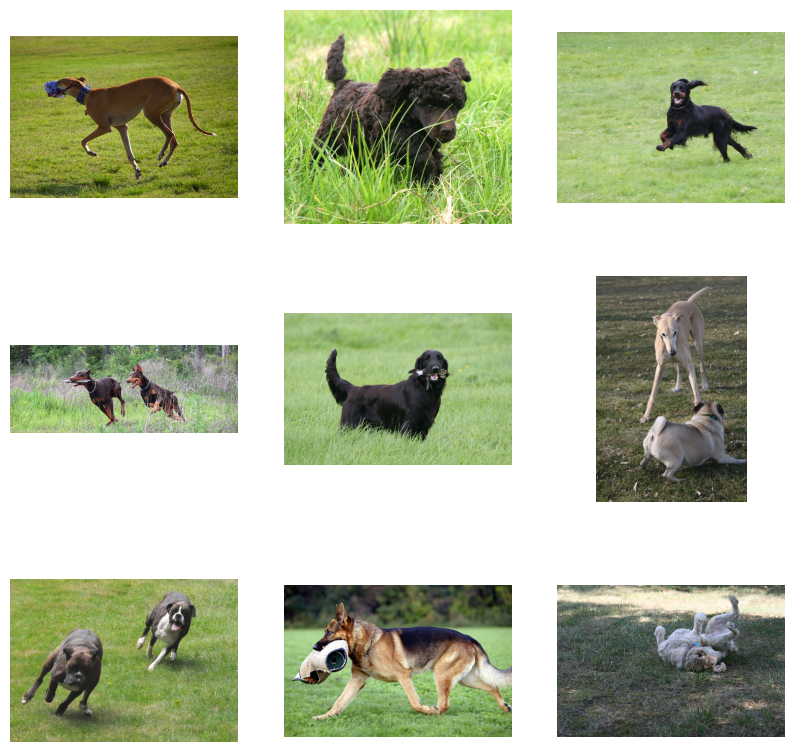

In [17]:
find_matches(model,
             image_embeddings,
             query="dogs on the grass",
             image_filenames=valid_df['image'].values,
             n=9)

In [25]:
from numpy import array

with open('similarities_str_time.pkl', 'rb') as fsim:
    similarities = pickle.load(fsim)
    print(array(similarities.cpu().numpy()).shape)
    print(similarities)

with open('values_str_time.pkl', 'rb') as fval_sim:
    values_sim = pickle.load(fval_sim)
    print(array(values_sim.cpu().numpy()).shape)
    print(values_sim)

with open('indices_str_time.pkl', 'rb') as find_sim:
    indices_sim = pickle.load(find_sim)
    print(array(indices_sim.cpu().numpy()).shape)
    print(indices_sim)

with open('matches_str_time.pkl', 'rb') as fmat_sim:
    matches_sim = pickle.load(fmat_sim)
    print(array(matches_sim).shape)
    print(matches_sim)

(1, 8090)
tensor([[0.8605, 0.8605, 0.8605,  ..., 0.8792, 0.8792, 0.8792]],
       device='cuda:0')
(45,)
tensor([0.9550, 0.9550, 0.9550, 0.9550, 0.9550, 0.9541, 0.9541, 0.9541, 0.9541,
        0.9541, 0.9540, 0.9540, 0.9540, 0.9540, 0.9540, 0.9539, 0.9539, 0.9539,
        0.9539, 0.9539, 0.9529, 0.9529, 0.9529, 0.9529, 0.9529, 0.9522, 0.9522,
        0.9522, 0.9522, 0.9522, 0.9522, 0.9522, 0.9522, 0.9522, 0.9522, 0.9519,
        0.9519, 0.9519, 0.9519, 0.9519, 0.9518, 0.9518, 0.9518, 0.9518, 0.9518],
       device='cuda:0')
(45,)
tensor([6250, 6251, 6252, 6253, 6254,  360,  361,  362,  363,  364, 1610, 1611,
        1612, 1613, 1614, 2765, 2766, 2767, 2768, 2769, 3175, 3176, 3177, 3178,
        3179, 5335, 5336, 5337, 5338, 5339, 6355, 6356, 6357, 6358, 6359, 4855,
        4856, 4857, 4858, 4859, 6800, 6801, 6802, 6803, 6804], device='cuda:0')
(9,)
['3559781965_d4ec00e506.jpg', '1361420539_e9599c60ae.jpg', '232874193_c691df882d.jpg', '2708634088_a4686be24c.jpg', '2860041212_797afd6ccf.

In [33]:
print(array(similarities.cpu().numpy()).shape)
similarities

(1, 8090)


tensor([[0.8605, 0.8605, 0.8605,  ..., 0.8792, 0.8792, 0.8792]],
       device='cuda:0')

In [32]:
print(array(similarities.squeeze(0).cpu().numpy()).shape)
similarities.squeeze(0)

(8090,)


tensor([0.8605, 0.8605, 0.8605,  ..., 0.8792, 0.8792, 0.8792], device='cuda:0')

In [35]:
from numpy import array

with open('img_sims_str_time.pkl', 'rb') as fimgsims:
    img_sims_pick = pickle.load(fimgsims)
    print(array(img_sims_pick.cpu().numpy()).shape)
    # print(img_sims_pick)

with open('text_sims_str_time.pkl', 'rb') as ftextsims:
    ftextsims = pickle.load(ftextsims)
    print(array(ftextsims.cpu().numpy()).shape)
    # print(ftextsims)

with open('logits_str_time.pkl', 'rb') as flogits:
    logits_pick = pickle.load(flogits)
    print(array(logits_pick.cpu().numpy()).shape)
    # print(logits_pick)

with open('targets_str_time.pkl', 'rb') as ftargets:
    targets_pick = pickle.load(ftargets)
    print(array(targets_pick.cpu().numpy()).shape)
    # print(targets_pick)



(26, 26)
26
26
(26, 26)
(26, 26)
(26, 26)


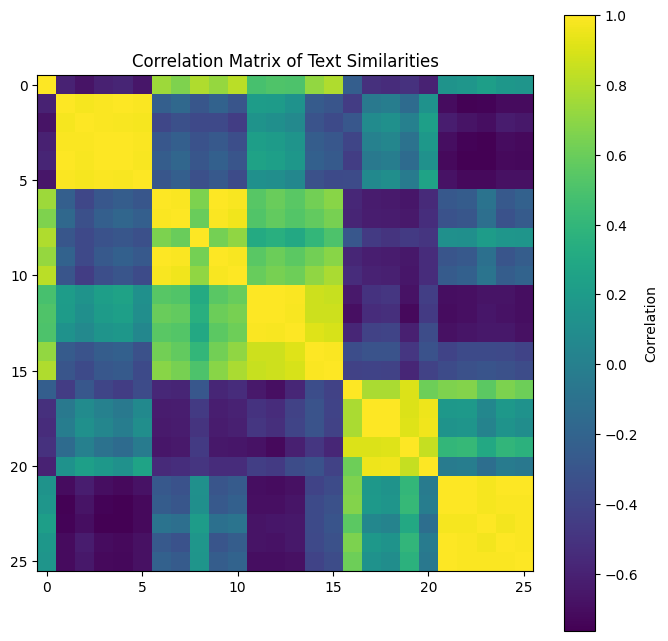

In [59]:
import numpy as np
import matplotlib.pyplot as plt

data_np = ftextsims.cpu().numpy()

# calculate the correlation matrix
corr_matrix = np.corrcoef(data_np)

plt.figure(figsize=(8, 8))
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')

plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of Text Similarities')

plt.show()

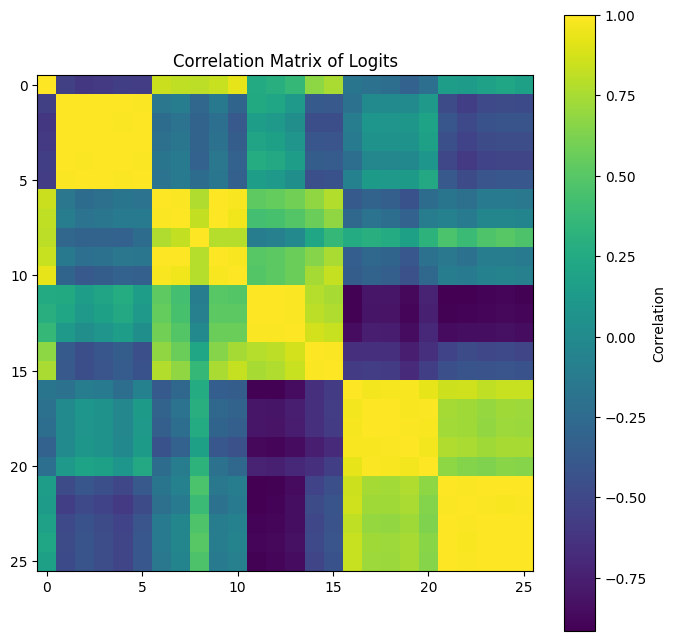

In [60]:
import numpy as np
import matplotlib.pyplot as plt

data_np = logits_pick.cpu().numpy()

# calculate the correlation matrix
corr_matrix = np.corrcoef(data_np)

plt.figure(figsize=(8, 8))
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')

plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of Logits')

plt.show()

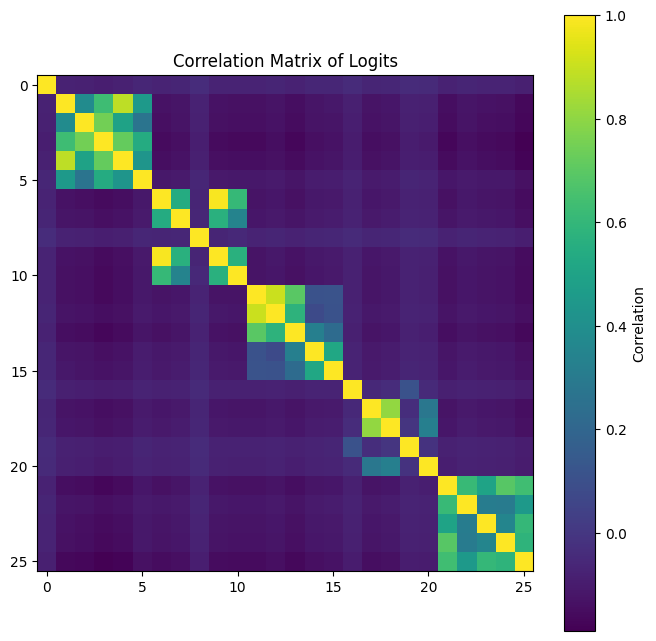

In [62]:
import numpy as np
import matplotlib.pyplot as plt

data_np = targets_pick.cpu().numpy()

# calculate the correlation matrix
corr_matrix = np.corrcoef(data_np)

plt.figure(figsize=(8, 8))
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')

plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of Logits')

plt.show()

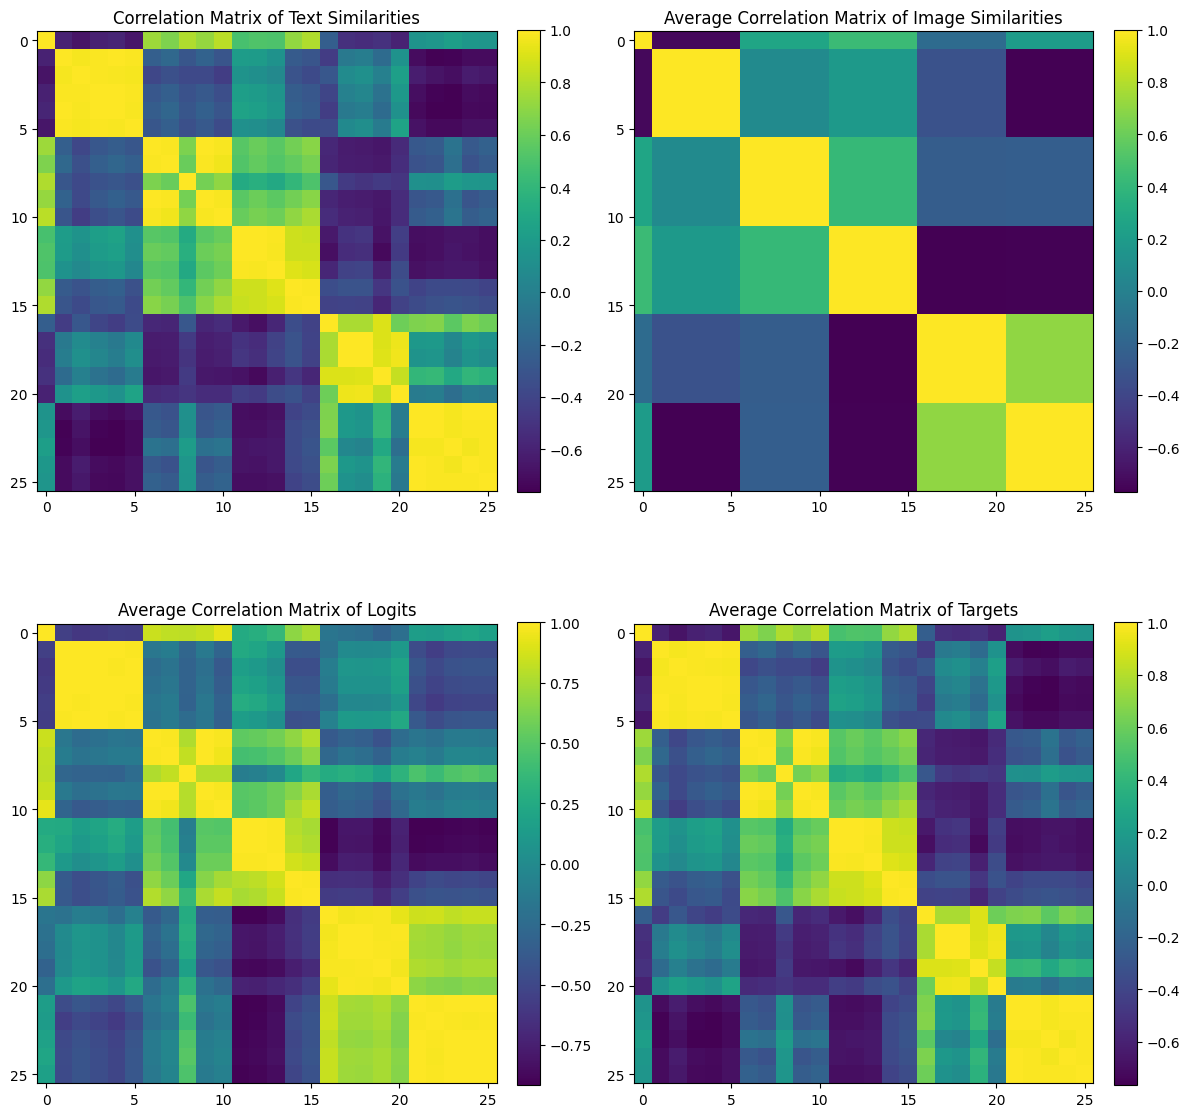

In [67]:
import numpy as np
import matplotlib.pyplot as plt


data_np_ftextsims = ftextsims.cpu().numpy()
corr_matrix_text_sim = np.corrcoef(data_np_ftextsims)

data_np_imgsims = img_sims_pick.cpu().numpy()
corr_matrix_img_sim = np.corrcoef(data_np_imgsims)

data_np_logits = logits_pick.cpu().numpy()
corr_matrix_logits = np.corrcoef(data_np_logits)

data_np_targets = targets_pick.cpu().numpy()
corr_matrix_targets = np.corrcoef(data_np_targets)


fig, axes = plt.subplots(2, 2, figsize=(12, 12))

im1 = axes[0, 0].imshow(corr_matrix_text_sim, cmap='viridis', interpolation='nearest')
axes[0, 0].set_title('Correlation Matrix of Text Similarities')
fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)


im2 = axes[0, 1].imshow(corr_matrix_img_sim, cmap='viridis', interpolation='nearest')
axes[0, 1].set_title('Average Correlation Matrix of Image Similarities')
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)


im3 = axes[1, 0].imshow(corr_matrix_logits, cmap='viridis', interpolation='nearest')
axes[1, 0].set_title('Average Correlation Matrix of Logits')
fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

im4 = axes[1, 1].imshow(corr_matrix_targets, cmap='viridis', interpolation='nearest')
axes[1, 1].set_title('Average Correlation Matrix of Targets')
fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
